Binary Classification Models in Keras
As you recall, a classification problem is one in which you are trying to predict a discrete, finite, and non-overlapping number of classes.
Binary classification is when you are trying to predict which of exactly 2 classes a sample belongs to. One example would be predicting
if a tumor were malignant or benign. Let’s try this in Keras.

In [14]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout

#Sci-kit Learn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [15]:
# We will also define a custom function to plot our learning history from the model.
# Learning history plotting function

# Learning history plotting function
def plot_history(history):

# Takes a keras model learning history and plots each metric
    
    metrics = history.history.keys()

    for metric in metrics:
        if not 'val' in metric:
            plt.plot(history.history[f'{metric}'], label=f'{metric}')
            if f'val_{metric}' in metrics:
                plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
            
            plt.legend()
            plt.title(f'{metric}')
            plt.show()

In [16]:
# Load and Process Data
# This dataset was taken from the University of Irvine Machine Learning Repository and describes the cell nuclei of breast tumors. It was
# first presented in 1992. The labels are ‘M’ for malignant and ‘B’ for benign tumors. Original Data source.
# load classification data

path = r"C:\Users\User\github_projects\Machine_Learning_with_Python\datasets\wisconsinBreastCancer.csv"

df_clf = pd.read_csv(path)
df_clf.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [17]:
# check for duplicates and null values
print(f'data info: {df_clf.info()}')
print(f'\n duplicate rows: {df_clf.duplicated().sum()}')

# There is no missing data, no duplicates, and all features are numeric except for the target. Keras models do not accept strings as
# targets like Sci-kit Learn models, so we will need to encode the labels. In this case, we will just use a simple .replace() call. We will
# also drop the ‘id’ column since it doesn’t contain any information about the tumor.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [18]:
# drop id and encode diagnosis
df_clf.drop(columns='id', inplace=True)
df_clf['diagnosis'].replace(['M','B'],[1,0], inplace=True)
df_clf.head()

# Since this is classification and our class balance is very important in both model performance and evaluation, let’s check the balance of
# classes.

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [19]:
# check classes and balance
df_clf['diagnosis'].value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

In [20]:
# split data

X = df_clf.drop(columns='diagnosis')
y = df_clf['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [21]:
# Since all of the features are numeric and there are no missing values, we can just scale it. Remember to always scale your data
# before using it for deep learning
# scale data

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [22]:
# Build the Model
# We will build a simple model with two hidden layers and 10 nodes in each layer. We will pass the number of features in the data to the
# input_dim= argument of the first layer so that Keras knows how to construct the implicit input layer.
# Since this is binary classification, the output layer will have one node and a ‘sigmoid’ activation function. The sigmoid function will
# change any value passed to it to a value between 0 and 1. That works because our classes in our target are 0 and 1. The predicted
# class will be the class number the predicted value is closest to. We will round this value later when we evaluate the model.

In [23]:
# create model architecture

input_dim = X_train_sc.shape[1]

clf_model = Sequential()

clf_model.add(Dense(10, input_dim=input_dim, activation='relu'))
clf_model.add(Dense(10, activation='relu'))
clf_model.add(Dense(1, activation='sigmoid'))

In [24]:
# The next step is to compile the model. We must consider 3 things to do this correctly:
# Loss
# We use a binary cross-entropy loss function, or ‘bce’. Recall that the loss function should always decrease as the model learns, so we
# need some metric that decreases as the model gets better. Metrics like accuracy or f1-score won’t work as a loss because they
# increase in value as the model converges to a good solution. Binary cross-entropy decreases as the error rate decreases. If you want
# to know more about loss functions, what they do, and when each should be used, you can research the documentation
# at: https://keras.io/api/losses/

# Optimizer
# There are many options for optimizers, which tend to improve the learning speed of a model. Adam is a popular one. You can research
# others at https://keras.io/api/optimizers/.

In [25]:
# Metrics
# The .compile() method lets us pass additional metrics to be tracked for each learning epoch. If we want to see how they change as the
# model learns we can list them here.
# This method recognizes some metrics as string shortcuts, such as ‘accuracy’, but others must be passed as class instances, such as
# metrics.Recall(). These class instances work differently than the functions that Sci-kit learn offers for evaluation purposes. They fit on
# the specific data for the model and should not be reused. Instantiate a new instance of each metrics class for each model iteration.
# There is no native class for the f1-score metric, however, it’s possible to create custom metric classes. The code for some
# implementations of f1 score is available online. They are a little complicated, but you could copy and paste them with attribution if you
# wanted to.
# You can learn more about available metrics here: https://keras.io/api/metrics/

In [28]:
# Since this is a classification problem, only classification metrics should be used here.
# compile model with metrics
clf_model.compile(loss='bce', optimizer='adam', metrics=['accuracy',

metrics.Precision(),
metrics.Recall()])

In [30]:
# Next we will fit the model on the data and use the validation data to identify any overfitting. The model will evaluate itself using all
# metrics passed in the .compile() call for every epoch on both sets of data, though it will only actually train on the training data. We will
# also set verbose=0 to avoid the long output of learning metrics by epoch. If you want to see the training metrics in real-time, you can
# change this argument.

history = clf_model.fit(X_train_sc, y_train, validation_data=(X_test_sc, y_test), epochs=15,verbose=0)

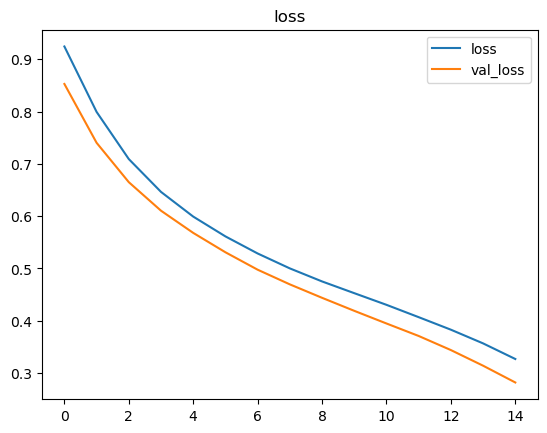

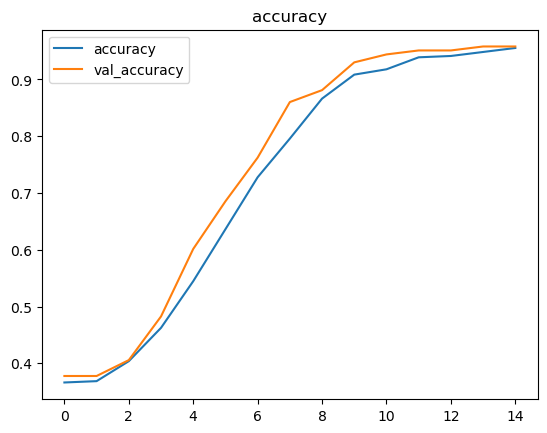

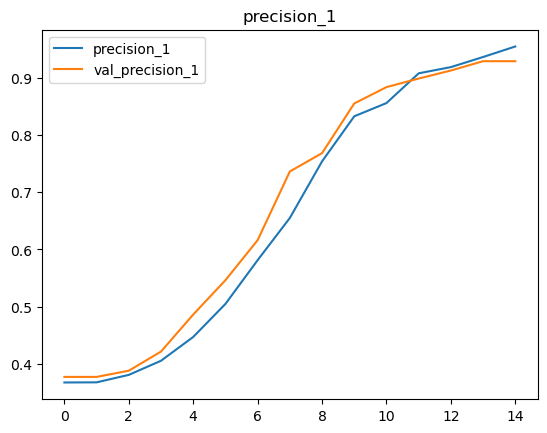

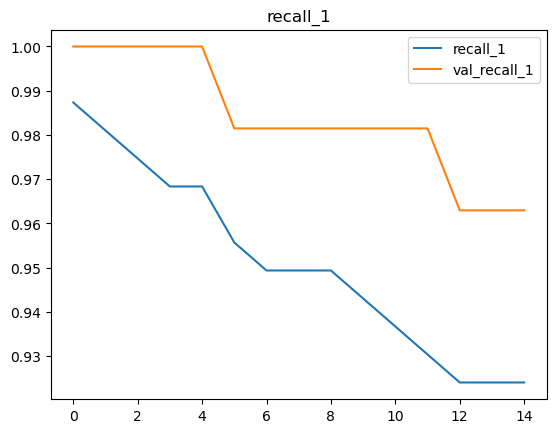

In [31]:
# Let’s use our custom function to see the history of learning using each of our passed metrics.
# plot learning history
plot_history(history)

5/5 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        89
           1       0.93      0.96      0.95        54

    accuracy                           0.96       143
   macro avg       0.95      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



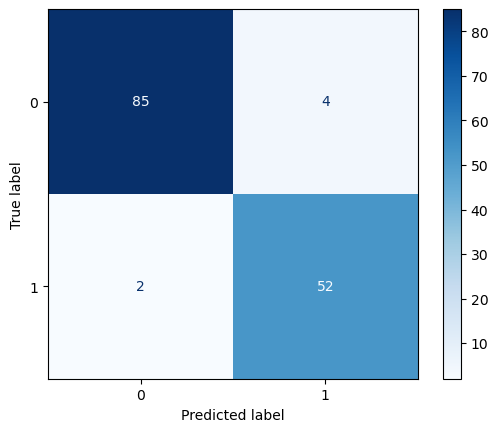

In [32]:
# evaluate model

#make predictions
y_preds = clf_model.predict(X_test_sc)

# round the predictions
y_preds = np.round(y_preds)

print(classification_report(y_test, y_preds))

ConfusionMatrixDisplay.from_predictions(y_test, y_preds, cmap='Blues');

In [ ]:
# Evaluation
# Our model seems to have performed well with higher precision on class 0 (benign) and a higher recall on class 1 (malignant). This is
# good. It shows us that when the model predicts benign, it is seldom wrong and it was successful in identifying most of the malignant
# tumors. The confusion matrix confirms this showing that it only misclassified one malignant tumor as benign.
# The notebook with the code for this lesson is available here.
# Note, due to the stochastic nature of deep learning models, you may not get the same results as this lesson, and the notebook
# outputs may not match.

In [ ]:
# Summary
# Binary classification models in Keras must have specific features for their output layers, loss functions, and metrics. The output layer
# must have one node and a sigmoid activation function. The loss function should be binary cross entropy, or ‘bce’. We can also pass it
# other classification metrics to track for each epoch of learning, such as precision, recall, and accuracy. There is no native
# implementation of f1-score in Keras. In order to use Scikit-Learn metrics functions, such as classification_report and
# ConfustionMatrixDisplay, you must round the model predictions to the nearest integer. The sigmoid activation function in the final layer
# outputs the probability of classes rather than the integer labels.